In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import seaborn as sb
sb.set()

<p style="font-size: 50px">CONCEPTUAL</p>
<p>1</p>

<AxesSubplot:xlabel='X'>

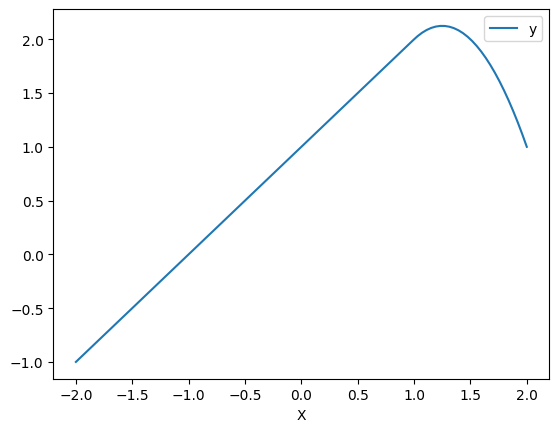

In [3]:
#conceptual 1
X = np.linspace(-2, 2, 100)
df = pd.DataFrame(X, columns = ['X'])
df['y'] = 1 + df['X'] #beta 0
df['y'] += (-2*(df['X']-1)**2)*(df['X']>=1).mul(1)
df.plot(x='X', y='y')

<p>Y intercept: 1<br>
X intercept: none in the specified range.<br>
The curve is linear between X= -2, and X=1 with the equation y=1+x and then turns into a quadratic equation between X=1 and X=2 with the equation of the line being  y=1+x−2(x−1)<sup>2</sup></p>

2

<AxesSubplot:xlabel='X'>

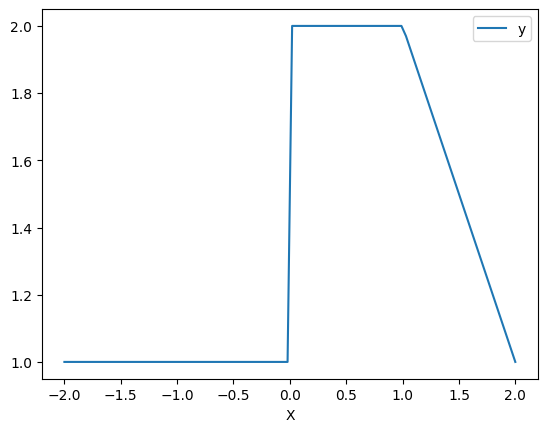

In [5]:
#conceptual 1
X = np.linspace(-2, 2, 100)
df = pd.DataFrame(X, columns = ['X'])


b1 = df['X'].between(0,2,'both').mul(1) - (df['X']-1)*(df['X'].between(1,2,'both').mul(1))
b2 = (df['X']-3)*df['X'].between(3,4,'both').mul(1) + df['X'].between(4,5,'right').mul(1)
df['y'] = 1 + b1 + 3*b2 #beta 0
df.plot(x='X', y='y')

There is a y intercept at Y=1
There are no x intercepts in the given range. 
The slope for this function is 0 for -2 to 0, and 0 to 1.
The slope for this function is extremely high near X=0
The slope of this function is 1+1-(X-1) from 1 to 2.

<p style="font-size:40px">Applied</p>

1.
1a.

3 0.08355308128270975


Text(0, 0.5, 'wage')

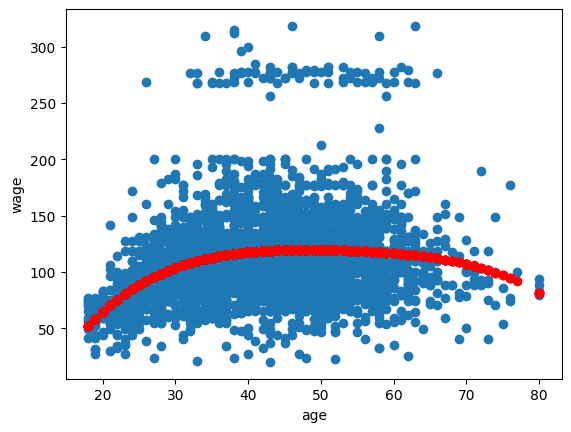

In [37]:
df = pd.read_csv("Wage.csv")
X = df['age'].values.reshape(-1,1)
y = df['wage']
plt.scatter(X, y)
scores = []
for i in range(1, 11):
    p = make_pipeline(PolynomialFeatures(i), LinearRegression())
    scores.append(np.mean((cross_val_score(p, X, y, cv=5, scoring='r2'))))
print(np.argmax(scores), max(scores))
p = make_pipeline(PolynomialFeatures(np.argmax(scores)+1), LinearRegression())
p.fit(X, y)
ypred = p.predict(X)
plt.scatter(X, ypred, color='r')
plt.xlabel('age')
plt.ylabel('wage')


step function thing here

2.

maritl
 2. Married          2074
1. Never Married     648
4. Divorced          204
5. Separated          55
3. Widowed            19
Name: maritl, dtype: int64
race
 1. White    2480
2. Black     293
3. Asian     190
4. Other      37
Name: race, dtype: int64
health
 2. >=Very Good    2142
1. <=Good          858
Name: health, dtype: int64
jobclass
 1. Industrial     1544
2. Information    1456
Name: jobclass, dtype: int64
sex
 1. Male    3000
Name: sex, dtype: int64


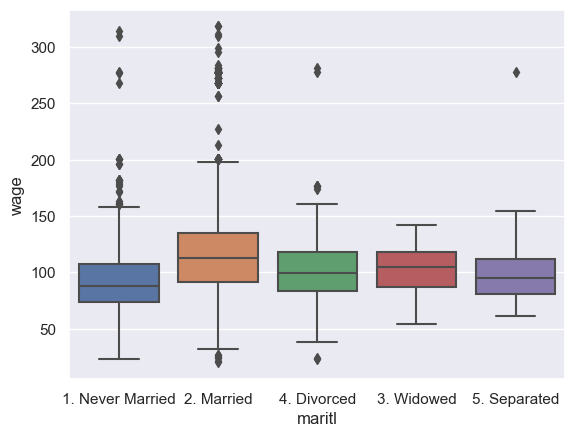

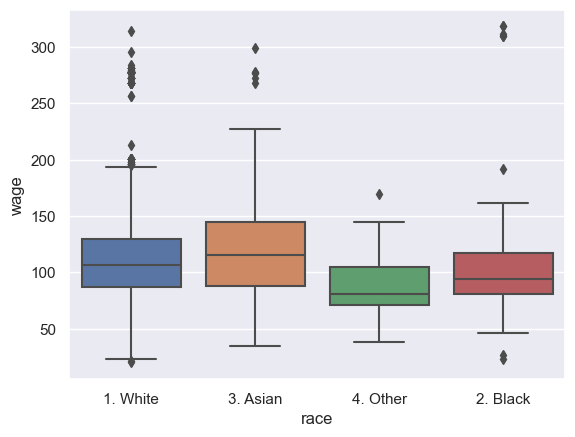

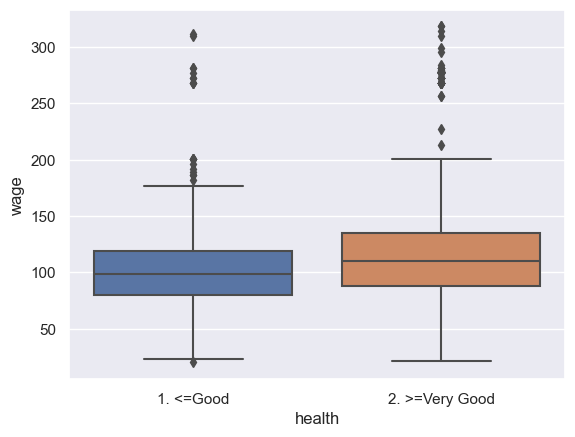

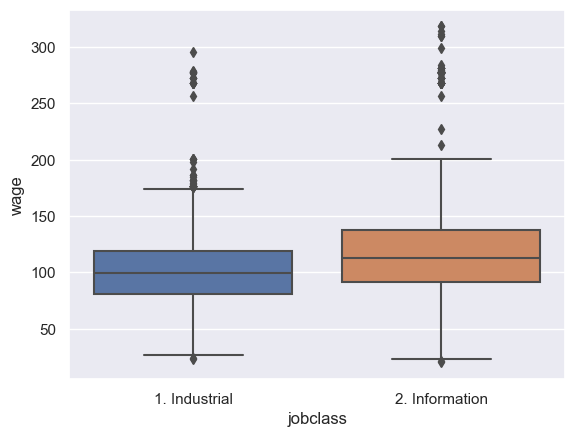

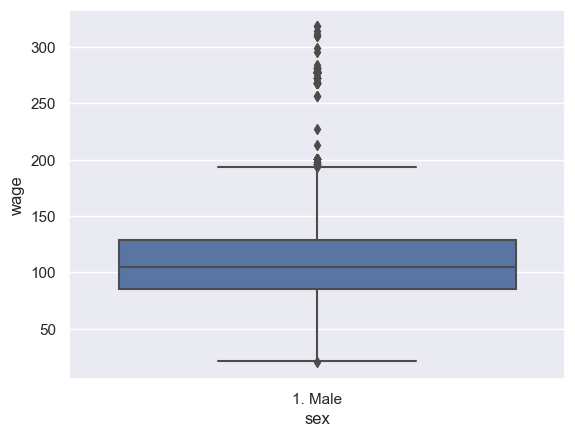

In [64]:
categoricals = ['maritl', 'race', 'health', 'jobclass','sex']
print("maritl\n", df['maritl'].value_counts())
print("race\n",df['race'].value_counts())
print("health\n", df['health'].value_counts())
print("jobclass\n", df['jobclass'].value_counts())
print("sex\n", df['sex'].value_counts())

for i in categoricals:
    sb.boxplot(x=df[i],y=df['wage'])
    plt.show()